In [1]:
import numpy as onp
import jax.numpy as np
import jax_cosmo as jc      # Jax-cosmo lib
from jemupk import *        # Jax Emulator of CLASS
import settings_gfpkq  as st         # configuration file (update 2/June/22)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 20
import matplotlib.patches as mpatches

In [3]:
param_emu = {}

param_emu['zmin'] = st.zmin
param_emu['zmax'] = st.zmax
param_emu['nz']   = st.nz

param_emu['kmin'] = st.k_min_h_by_Mpc
param_emu['kmax'] = st.k_max_h_by_Mpc
param_emu['nk']   = st.nk

param_emu['order'] = st.order
param_emu['x_trans'] = st.x_trans
param_emu['gf_y_trans'] = st.gf_args['y_trans']
param_emu['pl_y_trans'] = st.pl_args['y_trans']
param_emu['qf_y_trans'] = st.qf_args['y_trans']
param_emu['use_mean'] = st.use_mean

root_dir = "./"

assert st.sigma8, "Use sigma8 cosmology for this Emulator interface to Jax-cosmo"
print("Using: Omega_cdm h^2, Omega_b h^2, sigma8, ns, h")

param_emu['load_dir'] = root_dir + '/pknl_components' + st.d_one_plus+"_sig8"

param_emu['kernel_gf']    = kernel_RBF
param_emu['kernel_pklin'] = kernel_RBF
param_emu['kernel_qfunc'] = kernel_Matern12


Using: Omega_cdm h^2, Omega_b h^2, sigma8, ns, h


In [4]:
emu = JemuPk(param_emu)

In [5]:
cosmo_jax = jc.Planck15()

In [6]:
Nk=10*st.nk 
k_star = jnp.geomspace(st.k_min_h_by_Mpc, st.k_max_h_by_Mpc,Nk, endpoint=True) #h/Mpc
z_star = jnp.array([0.,1.])

In [7]:
pklin=emu.linear_pk(cosmo_jax,k_star, z_star)

In [10]:
pk_nonlin = emu.nonlinear_pk(cosmo_jax,k_star, z_star)

In [8]:
pklin.shape

(2, 400)

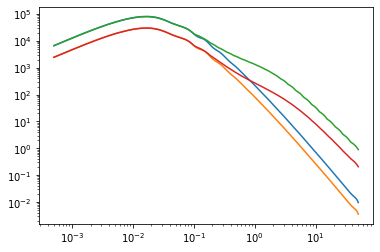

In [11]:
plt.plot(k_star,pklin[0])
plt.plot(k_star,pklin[1])
plt.plot(k_star,pk_nonlin[0])
plt.plot(k_star,pk_nonlin[1])
plt.xscale("log")
plt.yscale("log")

In [12]:
z_test = 1.0

In [13]:
func = lambda p: emu.linear_pk(p,k_star, z_star=z_test)
func_nl = lambda p: emu.nonlinear_pk(p,k_star, z_star=z_test)

In [14]:
pk_lin_emu = func(cosmo_jax)

In [15]:
pk_nonlin_emu = func_nl(cosmo_jax)

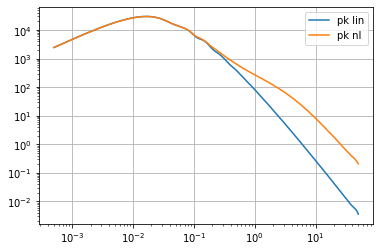

In [16]:
plt.plot(k_star,pk_lin_emu,label="pk lin")
plt.plot(k_star,pk_nonlin_emu,label="pk nl")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend();

In [18]:
jac_lin_emu = jax.jacfwd(func)(cosmo_jax)
jac_nonlin_emu = jax.jacfwd(func_nl)(cosmo_jax)


2022-06-06 15:26:47.339558: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:404] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f64[5,8]{1,0} custom-call(f64[5,5]{1,0} %Arg_0.1, f64[5,8]{0,1} %bitcast.3), custom_call_target="__cublas$gemm", backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"0\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]}}" failed. Falling back to default algorithm.  Per-algorithm errors:
2022-06-06 15:26:48.810362: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:404] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f64[8,1000]{1,0} custom-call(f64[8,5]{1,0} %bitcast.21, f64[1000,5]{1,0} %divide.6), custom_call_ta

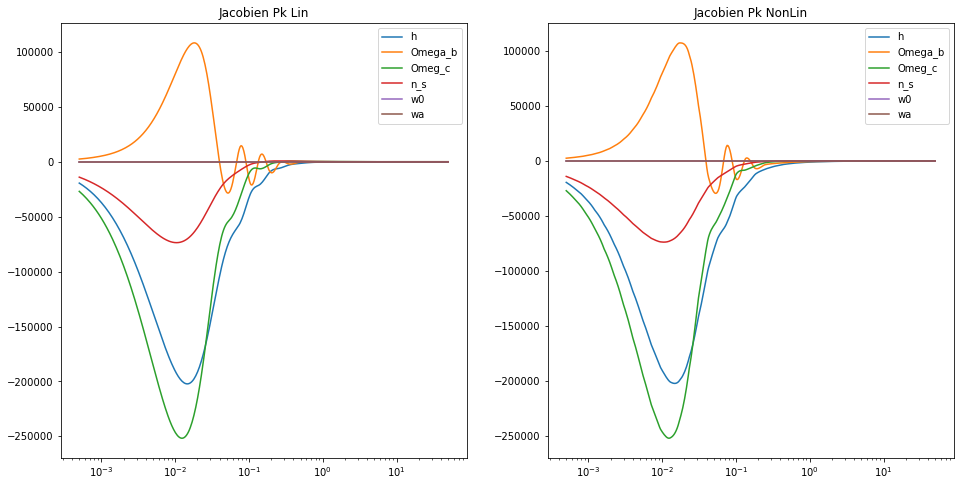

In [26]:
# Omega_c, Omega_b, h, n_s, sigma8, Omega_k, w0, wa, gamma=None
titles=["Jacobien Pk Lin","Jacobien Pk NonLin"]
fig,ax = plt.subplots(1,2,figsize=(16,8))
for i,jaco in enumerate([jac_lin_emu, jac_nonlin_emu]):
    ax[i].plot(k_star,jaco.h,label="h")
    ax[i].plot(k_star,jaco.Omega_b,label="Omega_b")
    ax[i].plot(k_star,jaco.Omega_c,label="Omeg_c")
    ax[i].plot(k_star,jaco.n_s,label="n_s")
    ax[i].plot(k_star,jaco.w0,label="w0")
    ax[i].plot(k_star,jaco.wa,label="wa")
    ax[i].set_xscale("log")
    ax[i].set_title(titles[i])
    ax[i].legend();

In [31]:
# Omega_c, Omega_b, h, n_s, sigma8, Omega_k, w0, wa, gamma=None
Omega_c_arr = jnp.linspace(cosmo_jax.Omega_c*0.5,cosmo_jax.Omega_c*1.5,10)/cosmo_jax.h**2
axes = jc.Cosmology(Omega_c=0,
                    Omega_b=None,h=None,n_s=None,sigma8=None,Omega_k=None,w0=None,wa=None,gamma=None)

In [34]:
pklin_Omegac_emu = jax.vmap(func, in_axes=(axes,))(jc.Cosmology(Omega_c=Omega_c_arr,
                                               Omega_b=cosmo_jax.Omega_b,
                                               h=cosmo_jax.h,
                                               n_s=cosmo_jax.n_s,
                                               sigma8=cosmo_jax.sigma8,
                                               Omega_k=cosmo_jax.Omega_k,
                                               w0=cosmo_jax.w0,
                                               wa=cosmo_jax.wa,
                                               gamma=cosmo_jax.gamma))

In [35]:
pk_nonlin_Omegac_emu = jax.vmap(func_nl, in_axes=(axes,))(jc.Cosmology(Omega_c=Omega_c_arr,
                                               Omega_b=cosmo_jax.Omega_b,
                                               h=cosmo_jax.h,
                                               n_s=cosmo_jax.n_s,
                                               sigma8=cosmo_jax.sigma8,
                                               Omega_k=cosmo_jax.Omega_k,
                                               w0=cosmo_jax.w0,
                                               wa=cosmo_jax.wa,
                                               gamma=cosmo_jax.gamma))

2022-06-06 15:38:29.518337: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:404] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.1 = f64[16,4000]{1,0} custom-call(f64[16,16]{1,0} %constant.25, f64[16,4000]{1,0} %bitcast.34), custom_call_target="__cublas$gemm", backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":0,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"0\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]}}" failed. Falling back to default algorithm.  Per-algorithm errors:
2022-06-06 15:38:29.518853: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:404] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.3 = f64[4,4000]{1,0} custom-call(f64[4,4]{1,0} %constant.26, f64[4,4000]{1,0} %bitcast.4

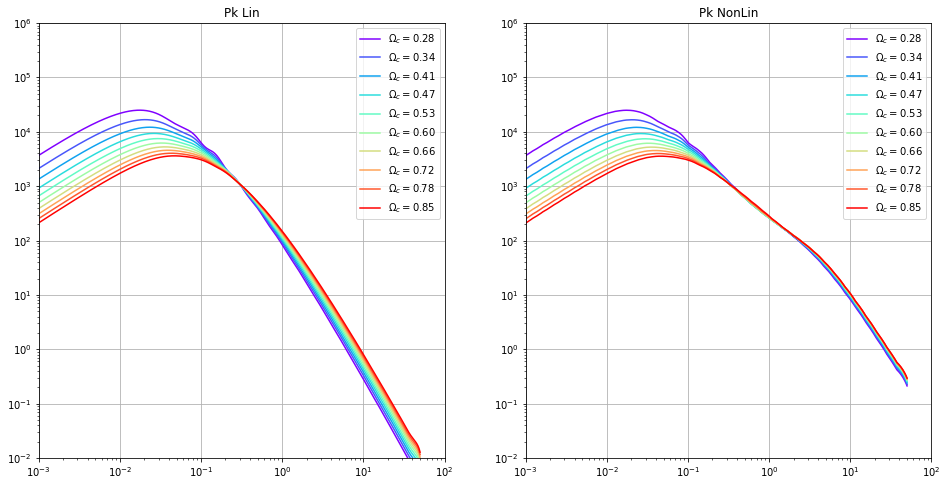

In [39]:
titles=["Pk Lin","Pk NonLin"]
fig,ax = plt.subplots(1,2,figsize=(16,8))
for iax,pk_emu in enumerate([pklin_Omegac_emu, pk_nonlin_Omegac_emu]):
    color = iter(mpl.cm.rainbow(np.linspace(0, 1, pk_emu.shape[0])))
    for i in range(pk_emu.shape[0]):
        c = next(color)
        ax[iax].plot(k_star,pk_emu[i,:],c=c,label=fr"$\Omega_c=${Omega_c_arr[i]:.2f}");
    ax[iax].set_xscale("log")
    ax[iax].set_yscale("log")
    ax[iax].set_title(titles[iax])
    ax[iax].grid()
    ax[iax].set_xlim([1e-3,1e2])
    ax[iax].set_ylim([1e-2,1e6])
    ax[iax].legend();